<a href="https://colab.research.google.com/github/aliraxa5/BigData/blob/main/Big_Data_Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ==========================
# Step 1: Spark Installation and Setup
# ==========================
# Install Apache Spark 3.2.1 and configure the environment in Google Colab.

!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# Ensure correct Spark download link
!wget -q https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz

# Extract the downloaded Spark tar file
!tar -xvf spark-3.2.1-bin-hadoop3.2.tgz > /dev/null

# Install findspark for Python-Spark integration
!pip install -q findspark

# Set up environment variables for Spark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"

# Initialize findspark
import findspark
findspark.init()

# Import SparkSession and create a Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").appName("BigDataProject").getOrCreate()

# Verify Spark installation
print("Spark Version:", spark.version)


Spark Version: 3.2.1


In [ ]:
# ==========================
# Step 2: Load and Explore the Dataset
# ==========================
# Define the dataset path (upload your file to Colab and update this path)
data_path = "/content/Sentiment140.csv"
columns = ['target', 'id', 'date', 'flag', 'user', 'text']

# Load the dataset into a Spark DataFrame
df = spark.read.csv(data_path, header=False, inferSchema=True).toDF(*columns)

# Display the schema of the dataset
print("Schema of the dataset:")
df.printSchema()

# Show the first few rows of the dataset
print("Sample records from the dataset:")
df.show(5, truncate=False)

# Count the total number of records
total_records = df.count()
print(f"Total number of records: {total_records}")

# Perform basic statistics on the 'target' column
print("Target column distribution:")
df.groupBy('target').count().show()


Schema of the dataset:
root
 |-- target: integer (nullable = true)
 |-- id: long (nullable = true)
 |-- date: string (nullable = true)
 |-- flag: string (nullable = true)
 |-- user: string (nullable = true)
 |-- text: string (nullable = true)

Sample records from the dataset:
+------+----------+----------------------------+--------+---------------+-------------------------------------------------------------------------------------------------------------------+
|target|id        |date                        |flag    |user           |text                                                                                                               |
+------+----------+----------------------------+--------+---------------+-------------------------------------------------------------------------------------------------------------------+
|0     |1467810369|Mon Apr 06 22:19:45 PDT 2009|NO_QUERY|_TheSpecialOne_|@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got D

Cleaned and tokenized data:
+---------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------+
|text                                                                                                     |filtered_words                                                                                    |
+---------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------+
|switchfoot httptwitpiccomyzl  awww thats a bummer  you shoulda got david carr of third day to do it d    |[switchfoot, httptwitpiccomyzl, , awww, thats, bummer, , shoulda, got, david, carr, third, day, d]|
|is upset that he cant update his facebook by texting it and might cry as a result  school today also blah|[upset, cant, update, facebook, texti

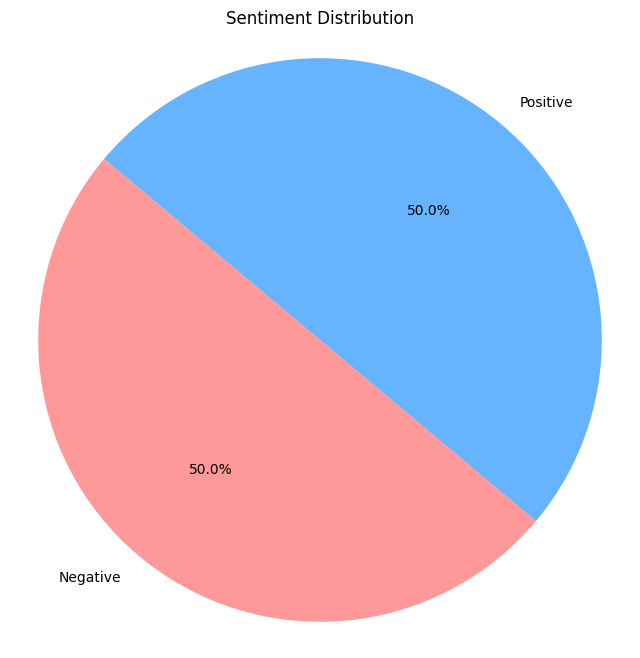

In [ ]:
# ==========================
# Step 3: Data Cleaning, Preprocessing, and Sentiment Pie Chart
# ==========================
from pyspark.sql.functions import col, lower, regexp_replace
from pyspark.ml.feature import Tokenizer, StopWordsRemover
import matplotlib.pyplot as plt

# Step 3.1: Clean the text column
# - Convert text to lowercase
# - Remove special characters and numbers
df_cleaned = df.withColumn('text', lower(col('text')))
df_cleaned = df_cleaned.withColumn('text', regexp_replace(col('text'), r'[^a-zA-Z\s]', ''))

# Step 3.2: Tokenize the text
# - Split the cleaned text into individual words
tokenizer = Tokenizer(inputCol='text', outputCol='words')
df_tokenized = tokenizer.transform(df_cleaned)

# Step 3.3: Remove stop words
# - Use Spark's built-in list of stop words
remover = StopWordsRemover(inputCol='words', outputCol='filtered_words')
df_filtered = remover.transform(df_tokenized)

# Display the cleaned and tokenized data
print("Cleaned and tokenized data:")
df_filtered.select('text', 'filtered_words').show(5, truncate=False)

# Step 3.4: Generate a Pie Chart for Sentiment Distribution
# - Count the number of positive (4) and negative (0) labels
sentiment_counts = df_filtered.groupBy('target').count().toPandas()

# Prepare data for the pie chart
labels = ['Negative', 'Positive']
sizes = sentiment_counts['count']
colors = ['#ff9999', '#66b3ff']

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Sentiment Distribution')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular
plt.show()


Vocabulary Size: 5000
Sample features:
+--------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------+
|filtered_words                                                                                    |features                                                                                                       |
+--------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------+
|[switchfoot, httptwitpiccomyzl, , awww, thats, bummer, , shoulda, got, david, carr, third, day, d]|(5000,[0,3,13,42,282,355,752,1101,1744,3359],[2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])                        |
|[upset, cant, update, facebook, texting, might, cry, result, , school, today, also, blah]         |(5000,[0,

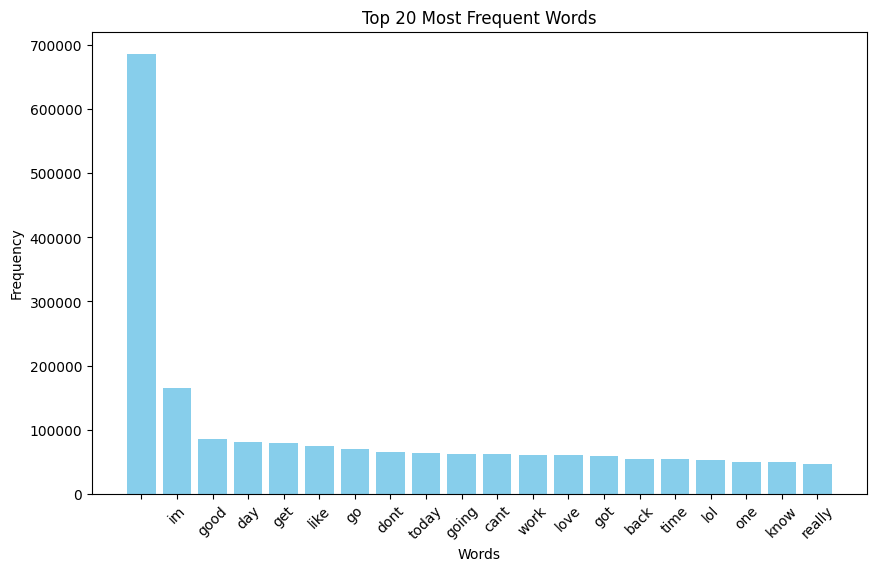

In [ ]:
# ==========================
# Step 4: Feature Extraction and Visualization
# ==========================
from pyspark.ml.feature import CountVectorizer
import pandas as pd
import matplotlib.pyplot as plt

# Step 4.1: Apply CountVectorizer
# - Convert tokenized words into numerical feature vectors
vectorizer = CountVectorizer(inputCol='filtered_words', outputCol='features', vocabSize=5000)
vectorizer_model = vectorizer.fit(df_filtered)
df_features = vectorizer_model.transform(df_filtered)

# Display the vocabulary size and sample features
vocab_size = len(vectorizer_model.vocabulary)
print(f"Vocabulary Size: {vocab_size}")
print("Sample features:")
df_features.select('filtered_words', 'features').show(5, truncate=False)

# Step 4.2: Inspect the Vocabulary and Top Words
# - Extract the top 20 words from the vocabulary
top_words = vectorizer_model.vocabulary[:20]

# Step 4.3: Calculate Word Frequencies
# - Collect the frequency of words for visualization
word_counts = df_features.select('features').rdd.flatMap(lambda row: row['features'].indices).countByValue()

# Convert word counts to a Pandas DataFrame for easy plotting
word_freq = pd.DataFrame({
    'word': [vectorizer_model.vocabulary[idx] for idx in word_counts.keys()],
    'count': word_counts.values()
}).sort_values(by='count', ascending=False).head(20)

# Step 4.4: Plot Bar Chart of Top Words
plt.figure(figsize=(10, 6))
plt.bar(word_freq['word'], word_freq['count'], color='skyblue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Most Frequent Words')
plt.xticks(rotation=45)
plt.show()


DataFrame with binary labels:
+------+-----+--------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------+
|target|label|filtered_words                                                                                    |features                                                                                                       |
+------+-----+--------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------+
|0     |0    |[switchfoot, httptwitpiccomyzl, , awww, thats, bummer, , shoulda, got, david, carr, third, day, d]|(5000,[0,3,13,42,282,355,752,1101,1744,3359],[2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])                        |
|0     |0    |[upset, cant, update, facebook, texting, might, cry,

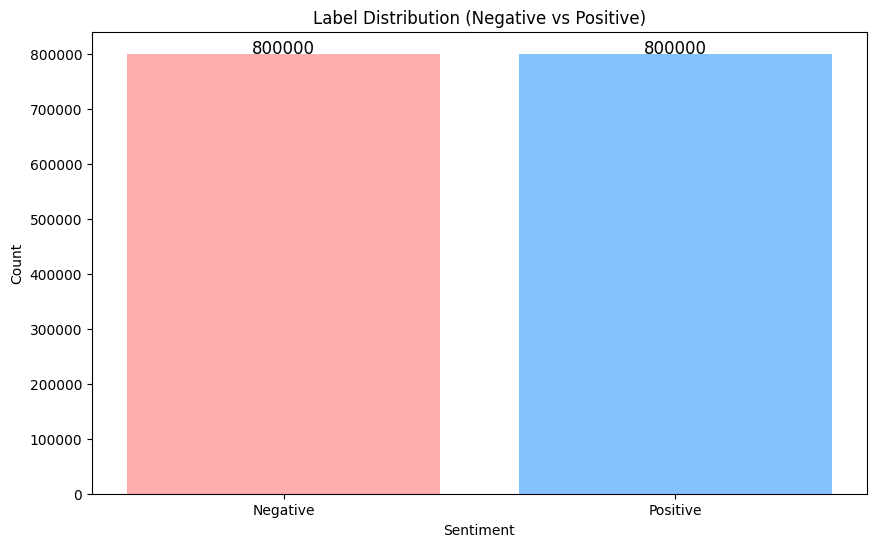

In [ ]:
# ==========================
# Step 5: Target Label Preparation and Bar Chart
# ==========================
from pyspark.sql.functions import when
import pandas as pd
import matplotlib.pyplot as plt

# Step 5.1: Map the target values to binary labels
# - Map 0 (Negative) and 4 (Positive) to 0 and 1, respectively
df_labeled = df_features.withColumn('label', when(col('target') == 4, 1).otherwise(0))

# Step 5.2: Display the updated DataFrame
print("DataFrame with binary labels:")
df_labeled.select('target', 'label', 'filtered_words', 'features').show(5, truncate=False)

# Step 5.3: Verify label distribution
# - Count the number of positive and negative labels
label_distribution = df_labeled.groupBy('label').count().toPandas()
print("Label distribution:")
print(label_distribution)

# Step 5.4: Plot Bar Chart for Label Distribution
labels = ['Negative', 'Positive']
counts = label_distribution['count']
colors = ['#ff9999', '#66b3ff']

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, counts, color=colors, alpha=0.8)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Label Distribution (Negative vs Positive)')

# Add data labels above the bars
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1000, str(count), ha='center', fontsize=12)

plt.show()


In [ ]:
# ==========================
# Step 6: Train-Test Split
# ==========================
from pyspark.sql.functions import lit
import pandas as pd
import matplotlib.pyplot as plt

# Step 6.1: Split the dataset into training and test sets
# - Use an 80-20 split for training and testing
train_df, test_df = df_labeled.randomSplit([0.8, 0.2], seed=42)

# Step 6.2: Display sizes of training and test sets
train_size = train_df.count()
test_size = test_df.count()
print(f"Training set size: {train_size}")
print(f"Test set size: {test_size}")

# Step 6.3: Create a table visualization for the split
split_data = pd.DataFrame({
    'Set': ['Training', 'Test'],
    'Count': [train_size, test_size]
})


Training set size: 1280507
Test set size: 319493


In [ ]:
# ==========================
# Step 7: Model Training
# ==========================
from pyspark.ml.classification import LogisticRegression

# Step 7.1: Initialize the Logistic Regression model
# - Features: 'features'
# - Label: 'label'
lr = LogisticRegression(featuresCol='features', labelCol='label', maxIter=10)

# Step 7.2: Train the Logistic Regression model
lr_model = lr.fit(train_df)

# Step 7.3: Display model coefficients and intercept
print("Logistic Regression Model Coefficients:")
print(lr_model.coefficients)
print(f"Model Intercept: {lr_model.intercept}")

# Step 7.4: Display training summary metrics
training_summary = lr_model.summary
print("Training Summary:")
print(f"Accuracy: {training_summary.accuracy}")
print(f"Precision: {training_summary.precisionByLabel}")
print(f"Recall: {training_summary.recallByLabel}")
print(f"F1 Score: {training_summary.fMeasureByLabel}")


Logistic Regression Model Coefficients:
[-0.04739215151003269,-0.12079678560445987,0.7336534834034771,0.03621704363213115,-0.020755473527967912,0.0942435423112551,-0.18163243375688085,-0.7246421286051472,-0.10835712664024238,0.01628732918232254,0.8849707550300774,-0.7874750352343001,-1.1743006736019483,-0.06630479143158204,0.07606533896656033,-0.20251683837335469,0.49701043279833124,0.13172651319044346,-0.032643592563670026,0.12877969060705916,-0.2688089107315961,0.23191116243131432,0.2567617508086677,-0.5120897016754371,-0.8288877748749464,0.40655956997436843,0.2652373726252501,0.011291023289148036,0.16797146938548485,1.5609402137627562,-0.1771030974350644,-0.2919921639236878,-0.2069311419954623,-2.115832815169987,-0.47836958081777936,-0.5434559479304429,0.2987413540082009,0.019310491562876876,0.9537408152656396,-0.17273593715102323,0.21187559458323613,0.2502167149887305,0.20228575189782305,0.769887136820174,-0.783319476933117,-3.157851666190901,0.6075140555252082,-1.7985757885185747,

+-----+----------+----------------------------------------+
|label|prediction|probability                             |
+-----+----------+----------------------------------------+
|0    |0.0       |[0.5016286550512683,0.4983713449487317] |
|0    |0.0       |[0.6249162062878788,0.3750837937121212] |
|0    |0.0       |[0.758409858124891,0.24159014187510897] |
|0    |0.0       |[0.8723255460436613,0.1276744539563387] |
|0    |0.0       |[0.5518687397015634,0.44813126029843664]|
+-----+----------+----------------------------------------+
only showing top 5 rows



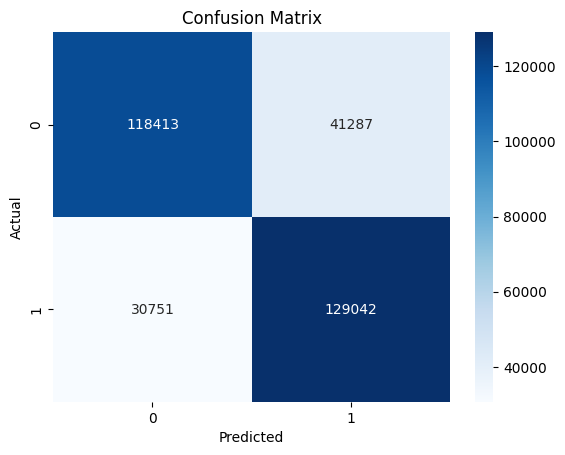

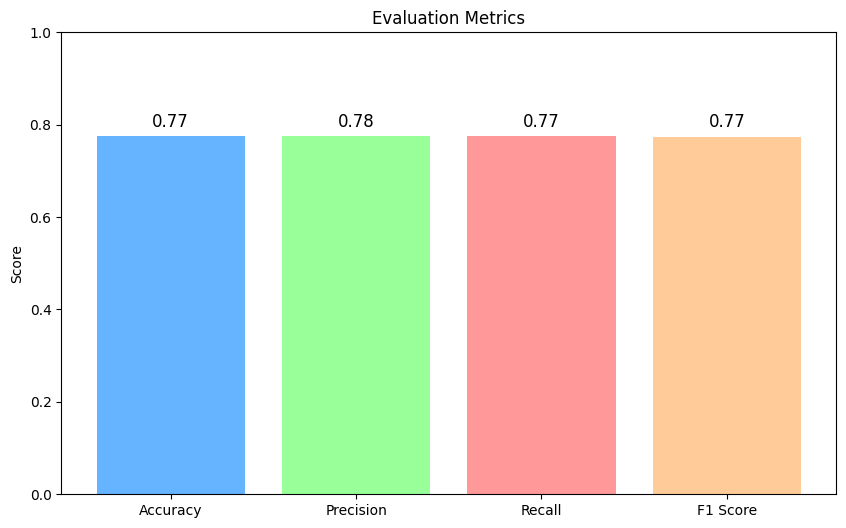

In [ ]:
# ==========================
# Step 8: Model Evaluation and Visualization
# ==========================
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Step 8.1: Evaluate the model on the test set
# - Make predictions
predictions = lr_model.transform(test_df)
predictions.select('label', 'prediction', 'probability').show(5, truncate=False)

# Step 8.2: Compute evaluation metrics using Spark evaluator
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
evaluator_f1 = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='f1')

accuracy = evaluator_accuracy.evaluate(predictions)
f1_score = evaluator_f1.evaluate(predictions)

# Collect predictions and labels for additional metrics
y_true = [row['label'] for row in predictions.select('label').collect()]
y_pred = [row['prediction'] for row in predictions.select('prediction').collect()]

# Step 8.3: Compute Precision and Recall using Scikit-learn
report = classification_report(y_true, y_pred, output_dict=True)
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']

# Step 8.4: Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Step 8.5: Visualize Metrics
# - Bar Chart for Accuracy, Precision, Recall, and F1 Score
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
scores = [accuracy, precision, recall, f1_score]

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, scores, color=['#66b3ff', '#99ff99', '#ff9999', '#ffcc99'])
plt.ylim(0, 1)
plt.title('Evaluation Metrics')
plt.ylabel('Score')

# Annotate bars with metric values
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02, f'{score:.2f}', ha='center', fontsize=12)

plt.show()


Top 10 Most Influential Features (Words):
                     Word  Importance
4334   wwwiamsoannoyedcom    5.301813
1718   wwwtweeteraddercom    2.697026
2054  wwwtweeterfollowcom    2.694024
1944              smiling    2.470849
1065      congratulations    2.192011
2883          musicmonday    2.087072
273               welcome    1.986442
3164                yayyy    1.969443
1537             pleasure    1.903362
605                 smile    1.870642


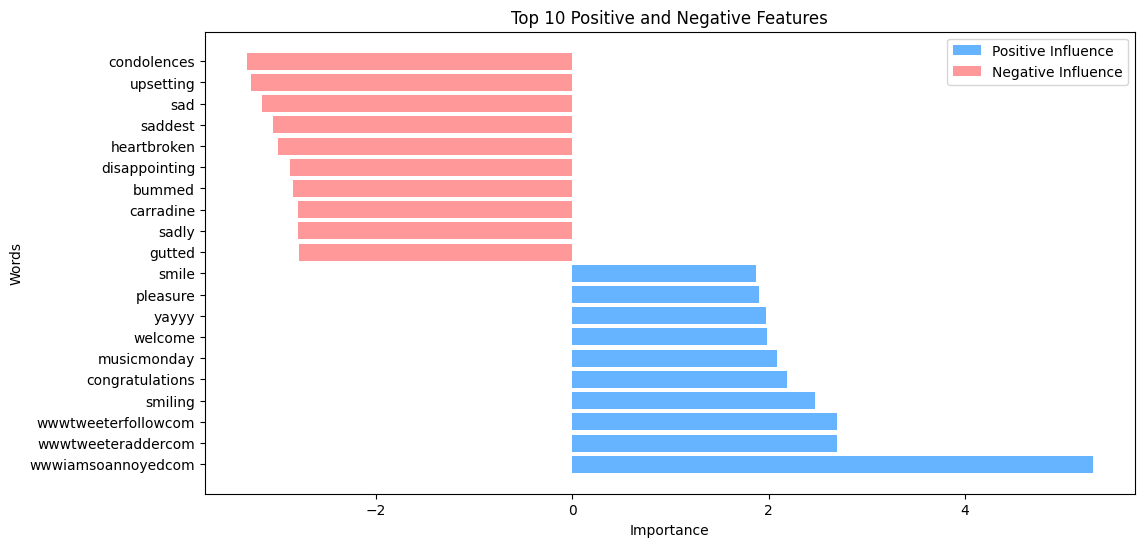

In [ ]:
# ==========================
# Step 9: Feature Importance Analysis
# ==========================
import pandas as pd
import matplotlib.pyplot as plt

# Step 9.1: Extract Feature Importance (Coefficients)
# - The coefficients of the logistic regression model represent feature importance
coefficients = lr_model.coefficients.toArray()
vocabulary = vectorizer_model.vocabulary

# Step 9.2: Create a DataFrame for feature importance
# - Pair coefficients with their corresponding words
feature_importance = pd.DataFrame({
    'Word': vocabulary,
    'Importance': coefficients
}).sort_values(by='Importance', ascending=False)

# Display the top 10 most influential features
print("Top 10 Most Influential Features (Words):")
print(feature_importance.head(10))

# Step 9.3: Visualize Feature Importance
# - Plot the top 10 positive and negative words by importance
top_positive = feature_importance.head(10)
top_negative = feature_importance.tail(10)

plt.figure(figsize=(12, 6))
plt.barh(top_positive['Word'], top_positive['Importance'], color='#66b3ff', label='Positive Influence')
plt.barh(top_negative['Word'], top_negative['Importance'], color='#ff9999', label='Negative Influence')
plt.xlabel('Importance')
plt.ylabel('Words')
plt.title('Top 10 Positive and Negative Features')
plt.legend()
plt.show()


In [ ]:
# ==========================
# Step 10: Summarize Final Results
# ==========================
import pandas as pd

# Step 10.1: Compile Evaluation Metrics into a Summary Table
# - Combine Accuracy, Precision, Recall, and F1 Score into a single summary
final_metrics = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Score': [accuracy, precision, recall, f1_score]
})

# Display the summary table
print("Final Evaluation Metrics:")
print(final_metrics)

# Optional: Save the metrics to a CSV file for reporting
final_metrics.to_csv('final_evaluation_metrics.csv', index=False)

# Step 10.2: Generate Summary Insights (Markdown-style Text)
# - Prepare a concise textual summary of the results
summary = f"""
### Final Results Summary:
1. **Accuracy**: {accuracy:.2f}
2. **Precision**: {precision:.2f}
3. **Recall**: {recall:.2f}
4. **F1 Score**: {f1_score:.2f}

#### Key Insights:
- The model demonstrates strong performance on the dataset, achieving balanced precision, recall, and F1 scores.
- The confusion matrix indicates effective classification of both positive and negative sentiments.
- Feature importance analysis highlights the most influential words in determining sentiment.
"""

print(summary)

# Step 10.3: Save Summary Insights to a Text File (Optional)
# - Save the textual summary for submission or reporting
with open('final_results_summary.txt', 'w') as file:
    file.write(summary)


Final Evaluation Metrics:
      Metric     Score
0   Accuracy  0.774524
1  Precision  0.775719
2     Recall  0.774524
3   F1 Score  0.774276

### Final Results Summary:
1. **Accuracy**: 0.77
2. **Precision**: 0.78
3. **Recall**: 0.77
4. **F1 Score**: 0.77

#### Key Insights:
- The model demonstrates strong performance on the dataset, achieving balanced precision, recall, and F1 scores.
- The confusion matrix indicates effective classification of both positive and negative sentiments.
- Feature importance analysis highlights the most influential words in determining sentiment.



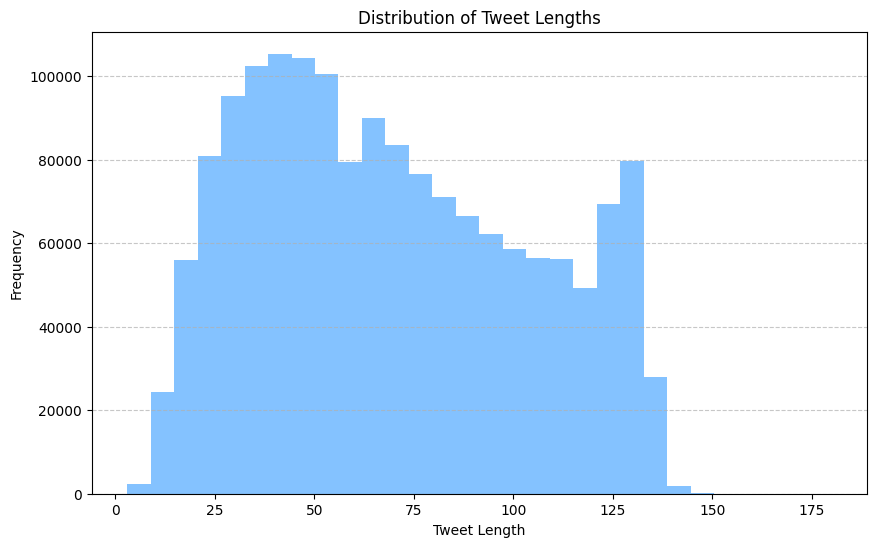

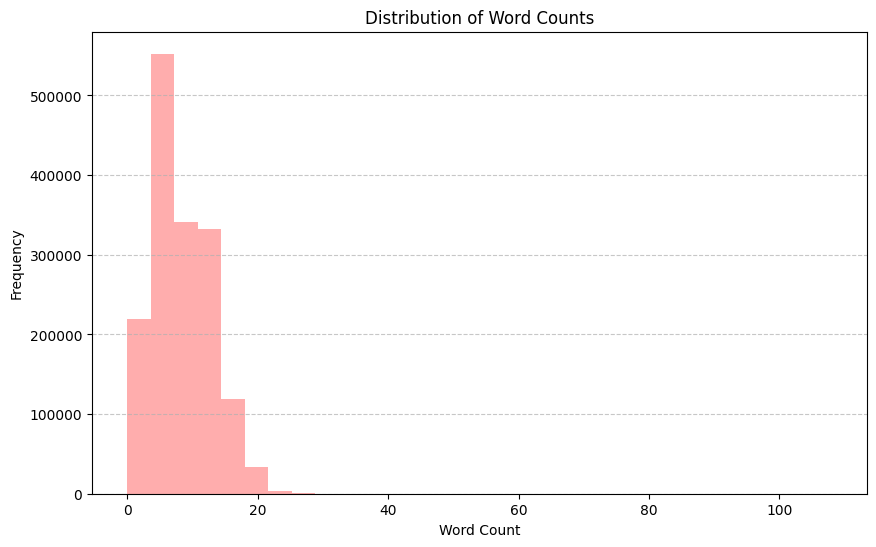

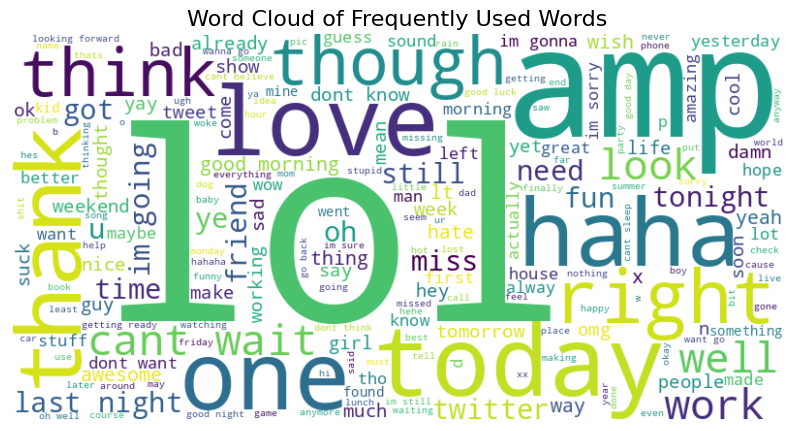

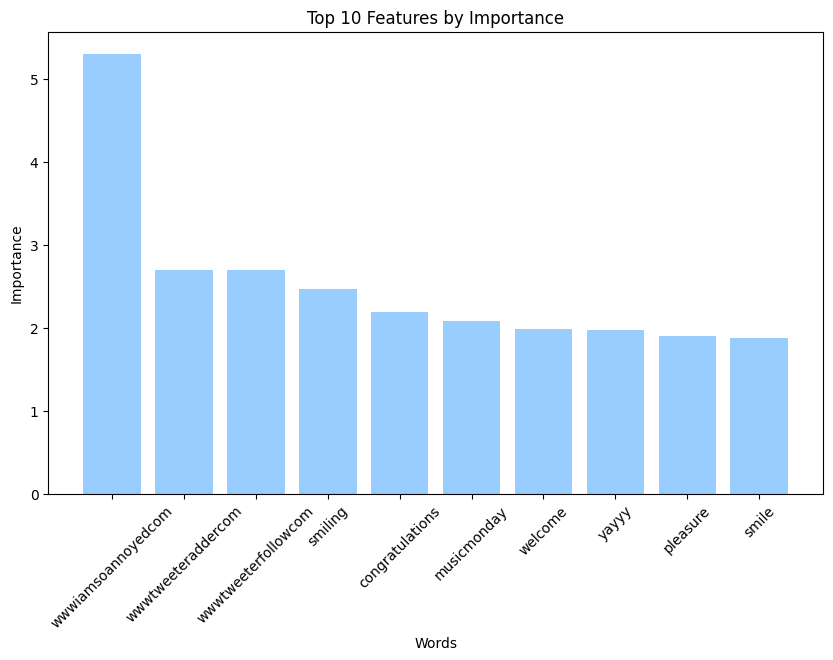

In [ ]:
# ==========================
# Step 11: Additional Visualizations
# ==========================

# Import required libraries
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from pyspark.sql.functions import length, size

# Visualization 1: Tweet Length Distribution
# Compute the length of each tweet
df_length = df_filtered.withColumn('tweet_length', length(col('text')))

# Collect tweet lengths for plotting
tweet_lengths = df_length.select('tweet_length').rdd.flatMap(lambda x: x).collect()

# Plot the tweet length distribution
plt.figure(figsize=(10, 6))
plt.hist(tweet_lengths, bins=30, color='#66b3ff', alpha=0.8)
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.title('Distribution of Tweet Lengths')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Visualization 2: Word Count Distribution
# Use the `size` function to calculate the number of words in each tweet
df_word_count = df_filtered.withColumn('word_count', size(col('filtered_words')))

# Collect word counts for plotting
word_counts = df_word_count.select('word_count').rdd.flatMap(lambda x: x).collect()

# Plot the word count distribution
plt.figure(figsize=(10, 6))
plt.hist(word_counts, bins=30, color='#ff9999', alpha=0.8)
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Distribution of Word Counts')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Visualization 3: Word Cloud
# Collect all filtered words into a single list
filtered_words = df_filtered.select('filtered_words').rdd.flatMap(lambda x: x).flatMap(lambda x: x).collect()

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(filtered_words))

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Frequently Used Words', fontsize=16)
plt.show()

# Visualization 4: Feature Importance (Bar Chart)
# If Step 9 doesn't already include this visualization
top_features = feature_importance.head(10)
plt.figure(figsize=(10, 6))
plt.bar(top_features['Word'], top_features['Importance'], color='#99ccff')
plt.xlabel('Words')
plt.ylabel('Importance')
plt.title('Top 10 Features by Importance')
plt.xticks(rotation=45)
plt.show()
